In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import logging

import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from original import better_MFF_database
from original.better_MFF_database import carve_confs
from original import Kernels
from original import GP_for_MFF

better_MFF_database.USE_ASAP = False
logging.basicConfig(level=logging.INFO)

In [35]:
# Parameters
directory = 'data/Fe_vac/'
r_cut = 4.45
sigma = 0.6
noise = 0.0001

combine_2b_3b = True

In [36]:
# # # ----------------------------------------
# # # Construct a configuration database
# # # ----------------------------------------


# n_data = 5000

# filename = directory + 'movie.xyz'

# traj = read(filename, index=slice(None), format='extxyz')

# elements, confs, forces, energies = carve_confs(traj, r_cut, n_data,
#                                                 forces_label='force', energy_label='energy', USE_ASAP=True)

# if not os.path.exists(directory):
#     os.makedirs(directory)

# np.save('{}/confs_cut={:.2f}.npy'.format(directory, r_cut), confs)
# np.save('{}/forces_cut={:.2f}.npy'.format(directory, r_cut), forces)
# np.save('{}/energies_cut={:.2f}.npy'.format(directory, r_cut), energies)

# lens = [len(conf) for conf in confs]

# logging.info('\n'.join((
#     'Number of atoms in a configuration:',
#     '   maximum: {}'.format(np.max(lens)),
#     '   minimum: {}'.format(np.min(lens)),
#     '   average: {:.4}'.format(np.mean(lens))
# )))


In [37]:
# ----------------------------------------
# Test a simple GP on the built database
# ----------------------------------------

# Parameters
# ntr = 100
ntr = 2
ntest = 5

# Get configurations and forces from file
confs = np.load(str(directory + 'confs_cut={:.2f}.npy'.format(r_cut)))
forces = np.load(str(directory + 'forces_cut={:.2f}.npy'.format(r_cut)))
numconfs = len(forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

# Separate into random testing and training dataset
# tr_confs, tr_forces = confs[ind[:ntr]], forces[ind[:ntr]]
# tst_confs, tst_forces = confs[ind[ntr:]], forces[ind[ntr:]]

# Use fixed training and testing dataset
tr_confs, tr_forces = confs[:ntr], forces[:ntr]
tst_confs, tst_forces = confs[-ntest - 1:-1], forces[-ntest - 1:-1]


In [38]:
two_body_train_forces = np.zeros((ntr, 3))
    
if combine_2b_3b:
    # First train with a 2 body
    ker_2 = Kernels.TwoBodySingleSpecies(theta=[sigma / 2.0, r_cut / 10.0, r_cut])
    gp_2 = GP_for_MFF.GaussianProcess(kernel=ker_2, noise=noise, optimizer=None)
    print('Training 2B GP')
    gp_2.fit(tr_confs, tr_forces)

    gp_2_name = 'gp_ker=2_ntr={}_sig={:.2f}_cut={:.2f}'.format(ntr, sigma / 2.0, r_cut)
    gp_2.save(directory + gp_2_name)

    # Calculate the predictions of the 2body on the training set
    for i in np.arange(ntr):
        two_body_train_forces[i] = gp_2.predict(np.reshape(tr_confs[i], (1, len(tr_confs[i]), 5)))


# Then train with a 2 body on the difference between tr_force and tr_force obtained with the two body
ker_3 = Kernels.ThreeBodySingleSpecies(theta=[sigma, r_cut / 10.0, r_cut])
gp_3 = GP_for_MFF.GaussianProcess(kernel=ker_3, noise=noise, optimizer=None)
print('Training 3B GP')
gp_3.fit(tr_confs, tr_forces - two_body_train_forces)

gp_3_name = 'gp_ker=3_ntr={}_sig={:.2f}_cut={:.2f}'.format(ntr, sigma, r_cut)
gp_3.save(directory + gp_3_name)

# Test the GP performance
print('Testing GP')

gp_3b_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))
gp_2b_error = np.zeros((ntest, 3))
gp_2b_forces = np.zeros((ntest, 3))

for i in np.arange(ntest):
    if combine_2b_3b:
        gp_2b_forces[i, :] = gp_2.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
        gp_2b_error[i, :] = gp_2b_forces[i, :] - tst_forces[i, :]
    gp_3b_forces[i, :] = gp_3.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_2b_forces[i, :] + gp_3b_forces[i, :] - tst_forces[i, :]

MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))
MAEF_2B = np.mean(np.sqrt(np.sum(np.square(gp_2b_error), axis=1)))
SMAE_2B = np.std(np.sqrt(np.sum(np.square(gp_2b_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('2 body MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF_2B, SMAE_2B))
print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))



Started compilation of theano two body single species kernels
Ended compilation of theano two body single species kernels
Training 2B GP
Saved Gaussian process with name: data/Fe_vac/gp_ker=2_ntr=2_sig=0.30_cut=4.45
Started compilation of theano three body single species kernels
Ended compilation of theano three body single species kernels
Training 3B GP
Saved Gaussian process with name: data/Fe_vac/gp_ker=3_ntr=2_sig=0.60_cut=4.45
Testing GP
2 body MAEF on forces: 0.3632 +- 0.1511
MAEF on forces: 0.3632 +- 0.1511
Relative MAEF on forces: 0.4428 +- 0.1842


In [39]:
tr_forces - two_body_train_forces

array([[6.370e-05, 6.168e-05, 7.339e-06],
       [1.258e-06, 2.617e-05, 6.509e-05]])

In [40]:
for i in np.arange(ntest):
    gp_error[i, :] = gp_2b_forces[i, :] + gp_3b_forces[i, :] - tst_forces[i, :]

MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))
MAEF_2B = np.mean(np.sqrt(np.sum(np.square(gp_2b_error), axis=1)))
SMAE_2B = np.std(np.sqrt(np.sum(np.square(gp_2b_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('2 body MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF_2B, SMAE_2B))
print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))


2 body MAEF on forces: 0.3632 +- 0.1511
MAEF on forces: 0.3632 +- 0.1511
Relative MAEF on forces: 0.4428 +- 0.1842


In [41]:
# %load_ext autoreload
# %autoreload 1
# %aimport original.create_MFF_grid

In [42]:
# ----------------------------------------
# Mapping
# ----------------------------------------
import original.create_MFF_grid as create_MFF_grid

grid_start = 1.5
elementslist = [26]
num = 100

mapping_2b = create_MFF_grid.SingleSpecies(gp_2, grid_start, r_cut, num, elementslist[0])
all_grids_2b = mapping_2b.build_grids()

remap_name_2b = 'MFF_{}b_ntr_{}_sig_{:.2f}_cut_{:.2f}.npy'.format(2, ntr, sigma / 2., r_cut)

np.save(directory + '/' + remap_name_2b, all_grids_2b)
print('Saved mapping with name {}'.format(remap_name_2b))


Saved mapping with name MFF_2b_ntr_2_sig_0.30_cut_4.45.npy


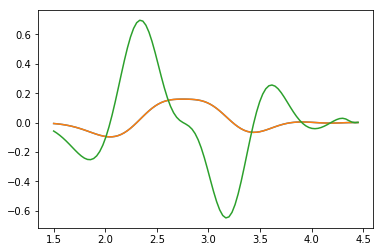

In [43]:
from m_ff.interpolation import Spline3D, Spline1D
import matplotlib.pyplot as plt

plt.plot(all_grids_2b[0], all_grids_2b[3])

mapped_2b = Spline1D(all_grids_2b[0],all_grids_2b[3])
plt.plot(all_grids_2b[0], mapped_2b(all_grids_2b[0], nu=0))
plt.plot(all_grids_2b[0], mapped_2b(all_grids_2b[0], nu=1))


In [44]:
from ase import Atoms
from asap3 import FullNeighborList
traj = []

forces = np.zeros((ntest, 3))

for i in np.arange(ntest):

    coords = np.vstack([[0,0,0], tst_confs[i][:,:3]])
    atoms = Atoms('Fe' + str(len(coords)), positions=coords)

    atoms.set_cell([100,100,100])
    nl = FullNeighborList(rCut=4.45, atoms=atoms, driftfactor=0.)

    inds, pos, dists2 = nl.get_neighbors(0)

    dists = np.sqrt(dists2)
    energy_local = mapped_2b(dists, nu=0)
    fs_scalars = - mapped_2b(dists, nu=1)

    potential_energies = np.sum(energy_local, axis=0)
    forces[i] = np.sum(pos/dists[:, np.newaxis] * fs_scalars[:, np.newaxis], axis=0)
    
    print('test {}'.format(i))
    print(tst_forces[i])
    print(forces[i])
    print(gp_2b_forces[i])
    


test 0
[ 0.511  0.139 -0.395]
[ 0.358  0.09  -0.695]
[ 0.358  0.09  -0.695]
test 1
[ 0.005 -0.392  0.453]
[ 0.181 -0.308  0.797]
[ 0.18  -0.308  0.797]
test 2
[ 0.717 -0.938 -0.072]
[ 0.883 -0.957  0.344]
[ 0.883 -0.957  0.344]
test 3
[-0.485 -1.257  0.24 ]
[-0.034 -0.968  0.172]
[-0.033 -0.967  0.172]
test 4
[0.277 0.011 0.085]
[0.284 0.1   0.061]
[0.284 0.1   0.061]


In [56]:
# ----------------------------------------
# Mapping 3b
# ----------------------------------------
from original import create_MFF_grid

grid_start = 1.5
elementslist = [26]

num = 100
# num = 20

mapping = create_MFF_grid.SingleSpecies(gp_3, grid_start, r_cut, num, elementslist[0], build2donly=False)
all_grids = mapping.build_grids()

remap_name = 'MFF_{}b_ntr_{}_sig_{:.2f}_cut_{:.2f}.npy'.format(3, ntr, sigma, r_cut)

np.save(directory + '/' + remap_name, all_grids)
print('Saved mapping with name {}'.format(remap_name))


Saved mapping with name MFF_3b_ntr_2_sig_0.60_cut_4.45.npy


In [71]:
grid_3b = Spline3D(all_grids[0],all_grids[0],all_grids[0],all_grids[4])


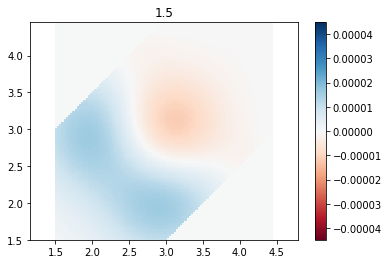

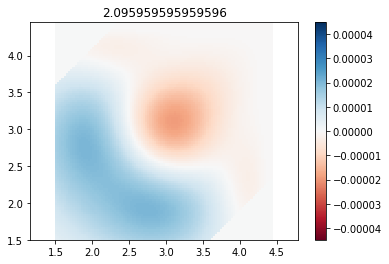

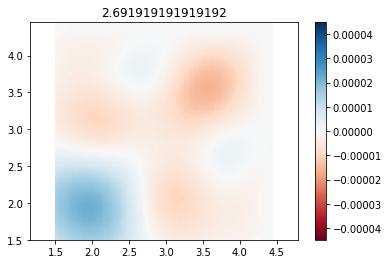

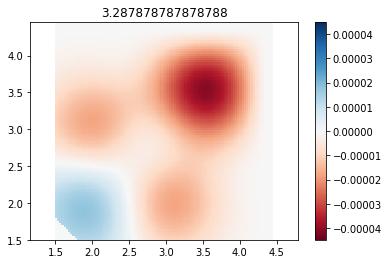

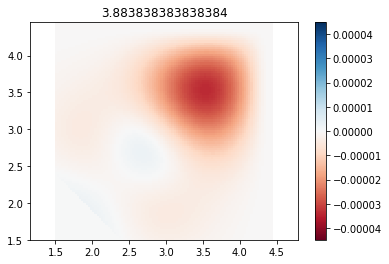

In [72]:
data = all_grids[4]
dists = np.linspace(grid_start, r_cut, num)
z_min, z_max = -np.max(np.abs(data)), np.max(np.abs(data))
for i in range(0, len(dists), 20):
    plt.title(dists[i])
    plt.pcolor(dists, dists, -data[:,:,i], cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar()
    plt.axis('equal')

    plt.show()

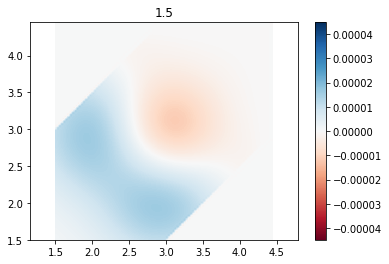

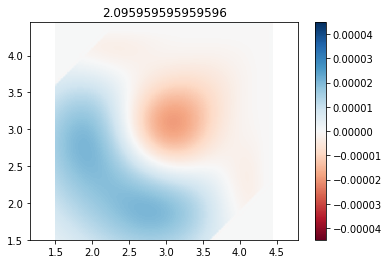

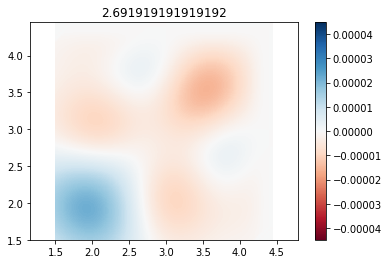

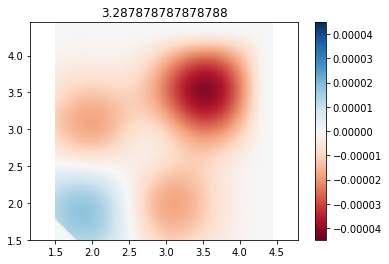

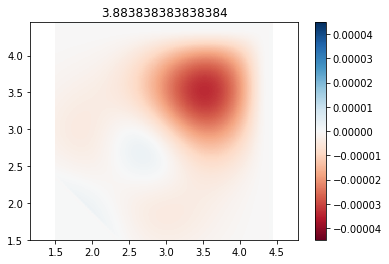

In [74]:
dist_range = np.linspace(grid_start, r_cut, 4*num)
for i in range(0, len(dists), 20):
    plt.title(dists[i])
    
    X, Y = np.meshgrid(dist_range, dist_range)
    m = grid_3b.ev_energy(X.flatten(), Y.flatten(), np.ones_like(X.flatten()) * dists[i]).reshape(4*num, 4*num)
    plt.pcolor(dist_range, dist_range, -m, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar()
    plt.axis('equal')

    plt.show()
    

In [75]:
def find_triplets(atoms, nl):
    # atomic_numbers = self.atoms.get_array('numbers', copy=False)

    indices, distances, positions, norms = [], [], dict(), dict()

    for i in range(len(atoms)):

        inds, pos, dists2 = nl.get_neighbors(i)

        # Limitation
        assert len(inds) is len(np.unique(inds)), "There are repetitive indices!\n{}".format(inds)

        # ignoring already visited atoms
        inds, pos, dists2 = inds[inds > i], pos[inds > i, :], dists2[inds > i]
        dists = np.sqrt(dists2)

        for local_ind, (j, pos_ij, dist_ij) in enumerate(zip(inds, pos, dists)):

            # Caching local displacement vectors
            positions[(i, j)], positions[(j, i)] = pos_ij, -pos_ij
            norms[(i, j)], norms[(j, i)] = pos_ij/dist_ij, -pos_ij/dist_ij

            for k, dist_ik in islice(zip(inds, dists), local_ind + 1, None):

                try:
                    jk_ind = list(nl[j]).index(k)
                except ValueError:
                    continue  # no valid triplet

                _, _, dists2_j = nl.get_neighbors(j)

                indices.append([i, j, k])
                distances.append([dist_ij, np.sqrt(dists2_j[jk_ind]), dist_ik])

    return np.array(indices), np.array(distances), positions, norms



In [76]:
from itertools import combinations, islice

forces_2b = np.zeros((ntest, 3))
forces_3b = np.zeros((ntest, 3))
potential_energies_3b = np.zeros((ntest, 1))
for xxi in np.arange(ntest):

    coords = np.vstack([[0,0,0], tst_confs[xxi][:,:3]])
    atoms = Atoms('Fe' + str(len(coords)), positions=coords)

    atoms.set_cell([100,100,100])
    nl = FullNeighborList(rCut=r_cut, atoms=atoms, driftfactor=0.)

    inds, pos, dists2 = nl.get_neighbors(0)

    dists = np.sqrt(dists2).reshape(-1, 1)
    norm = pos / dists

    energy_local = mapped_2b(dists, nu=0)
    fs_scalars = - mapped_2b(dists, nu=1)

    potential_energies_2b = 1 / 2 * np.sum(energy_local, axis=0)
    forces_2b[xxi] = np.sum(norm * fs_scalars, axis=0)

    # 3 body    
    indices, distances, positions, norms = find_triplets([atoms[0]], nl)
    
    d_ij, d_jk, d_ki = np.hsplit(distances, 3)
    mapped = mapped_3b.ev_all(d_ij, d_jk, d_ki)

    for (i, j, k), energy, dE_ij, dE_jk, dE_ki in zip(indices, mapped[0], mapped[1], mapped[2], mapped[3]):
        forces_3b[xxi] += - norms[(i, j)] * dE_ij - norms[(i, k)] * dE_ki

        potential_energies_3b[xxi] += energy

    print('test {}'.format(xxi))
    print(forces_2b[xxi])
    print(gp_2b_forces[xxi])
    print(forces_3b[xxi])
    print(gp_3b_forces[xxi])
    print(forces_2b[xxi]+forces_3b[xxi])
    print(gp_2b_forces[xxi]+gp_3b_forces[xxi])
    print(tst_forces[xxi])



test 0
[ 0.358  0.09  -0.695]
[ 0.358  0.09  -0.695]
[9.225e-05 1.476e-04 9.985e-05]
[9.213e-05 1.476e-04 9.962e-05]
[ 0.358  0.09  -0.695]
[ 0.358  0.09  -0.695]
[ 0.511  0.139 -0.395]
test 1
[ 0.181 -0.308  0.797]
[ 0.18  -0.308  0.797]
[-1.122e-04  1.463e-04 -1.055e-05]
[-1.126e-04  1.459e-04 -9.849e-06]
[ 0.181 -0.308  0.797]
[ 0.18  -0.308  0.797]
[ 0.005 -0.392  0.453]
test 2
[ 0.883 -0.957  0.344]
[ 0.883 -0.957  0.344]
[ 6.732e-06  8.109e-05 -6.675e-05]
[ 7.633e-06  8.065e-05 -6.674e-05]
[ 0.883 -0.957  0.344]
[ 0.883 -0.957  0.344]
[ 0.717 -0.938 -0.072]
test 3
[-0.034 -0.968  0.172]
[-0.033 -0.967  0.172]
[ 1.365e-04  3.161e-05 -3.921e-05]
[ 1.360e-04  3.174e-05 -3.970e-05]
[-0.034 -0.968  0.172]
[-0.033 -0.967  0.172]
[-0.485 -1.257  0.24 ]
test 4
[0.284 0.1   0.061]
[0.284 0.1   0.061]
[-1.101e-05  1.026e-04  7.744e-05]
[-1.091e-05  1.026e-04  7.725e-05]
[0.284 0.1   0.061]
[0.284 0.1   0.061]
[0.277 0.011 0.085]


In [77]:
i=0

coords = np.vstack([[0,0,0], tst_confs[i][:,:3]])
atoms = Atoms('Fe' + str(len(coords)), positions=coords)

atoms.set_cell([100,100,100])
nl = FullNeighborList(rCut=r_cut, atoms=atoms, driftfactor=0.)

# 3 body    
indices, distances, positions, norms = find_triplets([atoms[0]], nl)

d_ij, d_jk, d_ki = np.hsplit(distances, 3)
mapped = mapped_3b.ev_all(d_ij, d_jk, d_ki)

forces_3b_test = np.zeros((len(indices), 3))
forces_3b_test_energy = np.zeros((len(indices), 1))

for xi, ((i, j, k), energy, dE_ij, dE_jk, dE_ki) in enumerate(zip(indices, mapped[0], mapped[1], mapped[2], mapped[3])):
    forces_3b_test[xi] = - norms[(i, j)] * dE_ij - norms[(i, k)] * dE_ki
    forces_3b_test_energy[xi] = energy


forces_3b_gp_test = np.zeros((len(indices), 3))
forces_3b_gp_test_energy = np.zeros((len(indices), 1))
for xi, (i,j,k) in enumerate(indices):

    conf = np.array([[
        [*positions[(i,j)], 26, 26],
        [*positions[(i,k)], 26, 26]
    ]])

    forces_3b_gp_test[xi,:] = gp_3.predict(conf)
    forces_3b_gp_test_energy[xi] = gp_3.predict_energy(conf)

print('test {}'.format(i))
print(gp_3b_forces[i])
print(np.sum(forces_3b_gp_test, axis=0))
print(np.sum(forces_3b_test, axis=0))

# print(tst_forces[i])

test 0
[9.213e-05 1.476e-04 9.962e-05]
[9.213e-05 1.476e-04 9.962e-05]
[9.225e-05 1.476e-04 9.985e-05]


In [79]:

rot = np.array(
    [[ 0.649, -0.538,  0.538],
     [ 0.749,  0.329, -0.576],
     [ 0.133,  0.776,  0.616]])

d_ij,d_jk, d_ki = np.random.uniform(low=1.7, high=2.8,size=3)

print(d_ij,d_jk, d_ki)

assert np.logical_and(d_ij <= d_jk + d_ki, np.logical_and(d_jk <= d_ki + d_ij, d_ki <= d_ij + d_jk))

r_ij = np.array([d_ij, 0, 0])
r_ki_x = (d_ij**2 - d_jk**2 + d_ki**2) / (2*d_ij)
r_ki_y = np.sqrt(d_ki**2 - r_ki_x**2)
r_ki = np.array([r_ki_x, r_ki_y, 0])

energy, dE_ij, dE_jk, dE_ki = mapped_3b.ev_all(d_ij, d_jk, d_ki)

r_ij = np.array(np.dot(rot, r_ij))
r_ki = np.array(np.dot(rot, r_ki))


force = - r_ij/d_ij * dE_ij - r_ki/d_ki * dE_ki
print(energy, force)

conf = np.array([[
        [*r_ij, 26, 26],
        [*r_ki, 26, 26]
    ]])


print(gp_3.predict_energy(conf), gp_3.predict(conf))



2.0415621890895985 2.586371490398262 1.7550972150846045
[[-1.957e-05]] [[-9.294e-06  1.425e-06  9.432e-06]]
[[-1.956e-05]] [[-9.267e-06  1.452e-06  9.435e-06]]


In [80]:
# print(np.hstack([forces_3b_gp_test_energy, forces_3b_test_energy]))
# np.isclose(forces_3b_gp_test_energy, forces_3b_test_energy, atol=1e-03)
print(np.hstack([forces_3b_gp_test, forces_3b_test]))

[[-2.402e-05 -7.769e-06  9.087e-06 -2.401e-05 -7.770e-06  9.088e-06]
 [-1.186e-05  1.135e-05  1.266e-06 -1.185e-05  1.136e-05  1.266e-06]
 [-1.075e-05  3.940e-07  4.894e-07 -1.075e-05  3.966e-07  4.894e-07]
 [-2.848e-05  1.019e-05 -6.753e-06 -2.847e-05  1.019e-05 -6.754e-06]
 [-2.141e-05 -7.164e-07  2.296e-05 -2.141e-05 -7.160e-07  2.295e-05]
 [-2.289e-05  6.871e-06  7.979e-06 -2.288e-05  6.872e-06  7.980e-06]
 [-8.288e-06  1.621e-07  5.253e-06 -8.280e-06  1.623e-07  5.257e-06]
 [-1.007e-05  4.371e-07 -8.237e-06 -1.007e-05  4.372e-07 -8.238e-06]
 [-4.300e-06 -1.967e-08  1.526e-07 -4.305e-06 -1.995e-08  1.588e-07]
 [-2.012e-05 -2.068e-05  8.900e-07 -2.012e-05 -2.068e-05  8.897e-07]
 [-1.058e-05  2.263e-06  5.100e-07 -1.058e-05  2.261e-06  5.099e-07]
 [ 6.342e-07  8.244e-07 -6.935e-06  6.439e-07  8.342e-07 -6.933e-06]
 [ 7.823e-06 -1.333e-06 -2.219e-07  7.831e-06 -1.335e-06 -2.216e-07]
 [-1.460e-05 -1.520e-05  2.276e-05 -1.461e-05 -1.521e-05  2.276e-05]
 [-5.261e-06 -1.861e-05  1.946e-05